In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 

In [3]:
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [5]:
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [6]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical


In [7]:
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [8]:
import tensorflow as tf
import random as rn


In [9]:
import cv2                  
import numpy as np         
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm 

In [10]:
TRAIN_DIR = '../data/train'
TEST_DIR = '../data/test'
IMG_SIZE=100

In [11]:
def label_img(img):
    word_label = img.split('.')[0]
    return word_label

In [12]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),str(label)])
        
    shuffle(training_data)
    return training_data

In [13]:
train_data=create_train_data()
train_data=np.array(train_data)
print(train_data.shape)
X= np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y= np.array([i[1] for i in train_data])

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:44<00:00, 563.65it/s]


(25000, 2)


In [14]:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img)])
        
    shuffle(testing_data)
    return testing_data

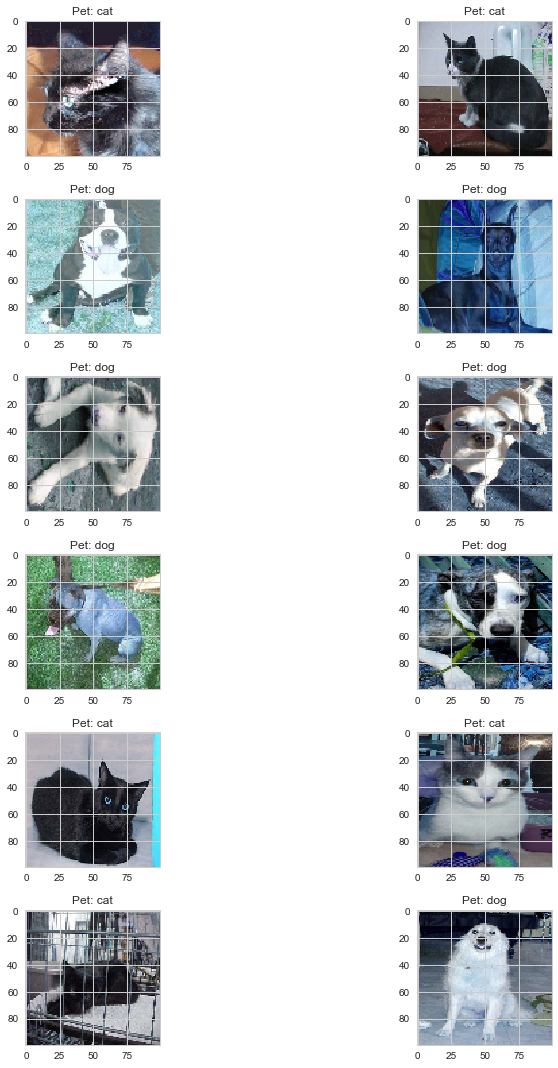

In [15]:
fig,ax=plt.subplots(6,2)
fig.set_size_inches(15,15)
for i in range(6):
    for j in range (2):
        l=rn.randint(0,len(Y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Pet: '+Y[l])
        
plt.tight_layout()

In [16]:
le=LabelEncoder()
Z=Y
Y=le.fit_transform(Y)
Y=to_categorical(Y)

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [18]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [19]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(2, activation = "sigmoid"))
 

In [20]:
batch_size=128
epochs=20

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.1)

In [21]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    horizontal_flip=True)
datagen.fit(x_train)

In [22]:
model.compile(optimizer=RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 96)        55392     
__________

In [24]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,callbacks=[red_lr])

Epoch 1/20
156/156 [==============================] - ETA: 14:32 - loss: 0.6935 - acc: 0.47 - ETA: 13:25 - loss: 2.3912 - acc: 0.43 - ETA: 12:52 - loss: 1.8272 - acc: 0.43 - ETA: 12:36 - loss: 1.5426 - acc: 0.46 - ETA: 12:24 - loss: 1.3727 - acc: 0.47 - ETA: 12:14 - loss: 1.2597 - acc: 0.47 - ETA: 12:06 - loss: 1.1805 - acc: 0.47 - ETA: 12:00 - loss: 1.1195 - acc: 0.48 - ETA: 11:52 - loss: 1.0722 - acc: 0.48 - ETA: 11:46 - loss: 1.0343 - acc: 0.48 - ETA: 11:40 - loss: 1.0033 - acc: 0.49 - ETA: 11:34 - loss: 0.9774 - acc: 0.49 - ETA: 11:28 - loss: 0.9555 - acc: 0.49 - ETA: 11:23 - loss: 0.9368 - acc: 0.49 - ETA: 11:17 - loss: 0.9205 - acc: 0.49 - ETA: 11:11 - loss: 0.9063 - acc: 0.49 - ETA: 11:06 - loss: 0.8938 - acc: 0.49 - ETA: 11:00 - loss: 0.8825 - acc: 0.50 - ETA: 10:55 - loss: 0.8735 - acc: 0.49 - ETA: 10:50 - loss: 0.8645 - acc: 0.50 - ETA: 10:45 - loss: 0.8563 - acc: 0.50 - ETA: 10:40 - loss: 0.8488 - acc: 0.50 - ETA: 10:36 - loss: 0.8423 - acc: 0.50 - ETA: 10:31 - loss: 0.8361 

156/156 [==============================] - ETA: 3:08 - loss: 0.6923 - acc: 0.500 - ETA: 7:40 - loss: 0.6912 - acc: 0.543 - ETA: 9:06 - loss: 0.6909 - acc: 0.537 - ETA: 9:51 - loss: 0.6909 - acc: 0.527 - ETA: 10:16 - loss: 0.6911 - acc: 0.51 - ETA: 10:45 - loss: 0.6908 - acc: 0.52 - ETA: 10:53 - loss: 0.6900 - acc: 0.52 - ETA: 11:02 - loss: 0.6960 - acc: 0.52 - ETA: 11:07 - loss: 0.6963 - acc: 0.51 - ETA: 11:05 - loss: 0.6959 - acc: 0.51 - ETA: 11:04 - loss: 0.6957 - acc: 0.51 - ETA: 11:01 - loss: 0.6955 - acc: 0.50 - ETA: 10:59 - loss: 0.6952 - acc: 0.51 - ETA: 10:57 - loss: 0.6950 - acc: 0.51 - ETA: 10:56 - loss: 0.6946 - acc: 0.51 - ETA: 10:54 - loss: 0.6950 - acc: 0.51 - ETA: 10:50 - loss: 0.6949 - acc: 0.51 - ETA: 10:46 - loss: 0.6946 - acc: 0.51 - ETA: 10:42 - loss: 0.6938 - acc: 0.51 - ETA: 10:38 - loss: 0.6937 - acc: 0.51 - ETA: 10:34 - loss: 0.6932 - acc: 0.52 - ETA: 10:30 - loss: 0.6939 - acc: 0.51 - ETA: 10:27 - loss: 0.6941 - acc: 0.52 - ETA: 10:23 - loss: 0.6940 - acc: 0.52

156/156 [==============================] - ETA: 12:54 - loss: 0.6957 - acc: 0.48 - ETA: 7:59 - loss: 0.6769 - acc: 0.5527 - ETA: 9:32 - loss: 0.6738 - acc: 0.588 - ETA: 10:16 - loss: 0.6704 - acc: 0.59 - ETA: 10:42 - loss: 0.6673 - acc: 0.59 - ETA: 11:01 - loss: 0.6602 - acc: 0.60 - ETA: 11:20 - loss: 0.6682 - acc: 0.58 - ETA: 11:26 - loss: 0.6727 - acc: 0.57 - ETA: 11:33 - loss: 0.6716 - acc: 0.57 - ETA: 11:40 - loss: 0.6728 - acc: 0.57 - ETA: 11:40 - loss: 0.6720 - acc: 0.58 - ETA: 11:43 - loss: 0.6704 - acc: 0.58 - ETA: 11:42 - loss: 0.6701 - acc: 0.58 - ETA: 11:39 - loss: 0.6721 - acc: 0.58 - ETA: 11:36 - loss: 0.6731 - acc: 0.58 - ETA: 11:32 - loss: 0.6719 - acc: 0.58 - ETA: 11:30 - loss: 0.6703 - acc: 0.59 - ETA: 11:29 - loss: 0.6705 - acc: 0.58 - ETA: 11:26 - loss: 0.6695 - acc: 0.59 - ETA: 11:24 - loss: 0.6694 - acc: 0.59 - ETA: 11:22 - loss: 0.6737 - acc: 0.59 - ETA: 11:18 - loss: 0.6736 - acc: 0.59 - ETA: 11:40 - loss: 0.6737 - acc: 0.59 - ETA: 12:02 - loss: 0.6738 - acc: 0.5

156/156 [==============================] - ETA: 13:58 - loss: 0.6468 - acc: 0.66 - ETA: 13:52 - loss: 0.7848 - acc: 0.58 - ETA: 10:20 - loss: 0.7383 - acc: 0.56 - ETA: 11:10 - loss: 0.7121 - acc: 0.59 - ETA: 11:36 - loss: 0.7198 - acc: 0.60 - ETA: 11:53 - loss: 0.7057 - acc: 0.61 - ETA: 12:04 - loss: 0.6958 - acc: 0.61 - ETA: 12:11 - loss: 0.6875 - acc: 0.62 - ETA: 12:13 - loss: 0.6802 - acc: 0.63 - ETA: 12:14 - loss: 0.6752 - acc: 0.63 - ETA: 12:14 - loss: 0.6737 - acc: 0.63 - ETA: 12:13 - loss: 0.6693 - acc: 0.63 - ETA: 12:12 - loss: 0.6669 - acc: 0.62 - ETA: 12:12 - loss: 0.6669 - acc: 0.62 - ETA: 12:09 - loss: 0.6659 - acc: 0.62 - ETA: 12:06 - loss: 0.6629 - acc: 0.62 - ETA: 12:02 - loss: 0.6605 - acc: 0.62 - ETA: 11:58 - loss: 0.6579 - acc: 0.62 - ETA: 11:54 - loss: 0.6609 - acc: 0.62 - ETA: 11:50 - loss: 0.6600 - acc: 0.62 - ETA: 11:48 - loss: 0.6590 - acc: 0.62 - ETA: 11:45 - loss: 0.6590 - acc: 0.62 - ETA: 11:44 - loss: 0.6584 - acc: 0.62 - ETA: 11:40 - loss: 0.6580 - acc: 0.62

156/156 [==============================] - ETA: 13:11 - loss: 0.5943 - acc: 0.70 - ETA: 13:02 - loss: 0.5862 - acc: 0.68 - ETA: 12:56 - loss: 0.5949 - acc: 0.66 - ETA: 10:27 - loss: 0.5928 - acc: 0.67 - ETA: 10:51 - loss: 0.5963 - acc: 0.67 - ETA: 11:05 - loss: 0.5903 - acc: 0.67 - ETA: 11:13 - loss: 0.6157 - acc: 0.66 - ETA: 11:18 - loss: 0.6193 - acc: 0.66 - ETA: 11:21 - loss: 0.6411 - acc: 0.64 - ETA: 11:22 - loss: 0.6404 - acc: 0.64 - ETA: 11:23 - loss: 0.6460 - acc: 0.63 - ETA: 11:22 - loss: 0.6472 - acc: 0.63 - ETA: 11:21 - loss: 0.6456 - acc: 0.63 - ETA: 11:19 - loss: 0.6425 - acc: 0.64 - ETA: 11:17 - loss: 0.6407 - acc: 0.64 - ETA: 11:14 - loss: 0.6354 - acc: 0.65 - ETA: 11:11 - loss: 0.6310 - acc: 0.65 - ETA: 11:09 - loss: 0.6305 - acc: 0.65 - ETA: 11:06 - loss: 0.6295 - acc: 0.65 - ETA: 11:02 - loss: 0.6269 - acc: 0.65 - ETA: 10:59 - loss: 0.6261 - acc: 0.65 - ETA: 10:55 - loss: 0.6275 - acc: 0.65 - ETA: 10:51 - loss: 0.6267 - acc: 0.66 - ETA: 10:47 - loss: 0.6263 - acc: 0.66

156/156 [==============================] - ETA: 13:11 - loss: 0.6803 - acc: 0.57 - ETA: 13:05 - loss: 0.6784 - acc: 0.56 - ETA: 12:59 - loss: 0.6670 - acc: 0.56 - ETA: 12:52 - loss: 0.6854 - acc: 0.58 - ETA: 10:53 - loss: 0.7256 - acc: 0.56 - ETA: 11:07 - loss: 0.7116 - acc: 0.57 - ETA: 11:15 - loss: 0.6945 - acc: 0.59 - ETA: 11:20 - loss: 0.7141 - acc: 0.58 - ETA: 11:24 - loss: 0.7047 - acc: 0.59 - ETA: 11:25 - loss: 0.6926 - acc: 0.60 - ETA: 11:25 - loss: 0.6819 - acc: 0.61 - ETA: 11:24 - loss: 0.6753 - acc: 0.61 - ETA: 11:22 - loss: 0.6713 - acc: 0.61 - ETA: 11:20 - loss: 0.6683 - acc: 0.61 - ETA: 11:17 - loss: 0.6676 - acc: 0.61 - ETA: 11:15 - loss: 0.6653 - acc: 0.62 - ETA: 11:12 - loss: 0.6673 - acc: 0.62 - ETA: 11:08 - loss: 0.6666 - acc: 0.62 - ETA: 11:05 - loss: 0.6634 - acc: 0.62 - ETA: 11:02 - loss: 0.6614 - acc: 0.62 - ETA: 10:58 - loss: 0.6585 - acc: 0.62 - ETA: 10:54 - loss: 0.6569 - acc: 0.63 - ETA: 10:50 - loss: 0.6537 - acc: 0.63 - ETA: 10:46 - loss: 0.6475 - acc: 0.64

156/156 [==============================] - ETA: 13:38 - loss: 0.6068 - acc: 0.65 - ETA: 13:29 - loss: 0.5915 - acc: 0.68 - ETA: 13:25 - loss: 0.6042 - acc: 0.66 - ETA: 13:17 - loss: 0.5969 - acc: 0.68 - ETA: 13:16 - loss: 0.5900 - acc: 0.69 - ETA: 11:33 - loss: 0.5822 - acc: 0.69 - ETA: 11:48 - loss: 0.5923 - acc: 0.68 - ETA: 12:00 - loss: 0.5901 - acc: 0.68 - ETA: 12:08 - loss: 0.5898 - acc: 0.68 - ETA: 12:12 - loss: 0.5864 - acc: 0.69 - ETA: 12:15 - loss: 0.5933 - acc: 0.68 - ETA: 12:12 - loss: 0.5939 - acc: 0.68 - ETA: 12:10 - loss: 0.5929 - acc: 0.68 - ETA: 12:08 - loss: 0.5911 - acc: 0.69 - ETA: 12:04 - loss: 0.5953 - acc: 0.68 - ETA: 12:00 - loss: 0.5942 - acc: 0.69 - ETA: 11:55 - loss: 0.5923 - acc: 0.69 - ETA: 11:50 - loss: 0.5934 - acc: 0.69 - ETA: 11:45 - loss: 0.5883 - acc: 0.69 - ETA: 11:40 - loss: 0.5978 - acc: 0.69 - ETA: 11:35 - loss: 0.6497 - acc: 0.68 - ETA: 11:31 - loss: 0.6503 - acc: 0.67 - ETA: 11:27 - loss: 0.6499 - acc: 0.67 - ETA: 11:21 - loss: 0.6478 - acc: 0.67

156/156 [==============================] - ETA: 13:09 - loss: 0.4889 - acc: 0.74 - ETA: 13:04 - loss: 0.6274 - acc: 0.69 - ETA: 12:55 - loss: 0.6546 - acc: 0.68 - ETA: 12:50 - loss: 0.6283 - acc: 0.69 - ETA: 12:45 - loss: 0.6181 - acc: 0.70 - ETA: 12:39 - loss: 0.6205 - acc: 0.69 - ETA: 11:13 - loss: 0.6249 - acc: 0.69 - ETA: 11:20 - loss: 0.6236 - acc: 0.68 - ETA: 11:22 - loss: 0.6195 - acc: 0.68 - ETA: 11:23 - loss: 0.6342 - acc: 0.67 - ETA: 11:24 - loss: 0.6335 - acc: 0.67 - ETA: 11:23 - loss: 0.6331 - acc: 0.67 - ETA: 11:21 - loss: 0.6345 - acc: 0.67 - ETA: 11:20 - loss: 0.6343 - acc: 0.66 - ETA: 11:19 - loss: 0.6354 - acc: 0.66 - ETA: 11:18 - loss: 0.6332 - acc: 0.66 - ETA: 11:15 - loss: 0.6308 - acc: 0.66 - ETA: 11:14 - loss: 0.6259 - acc: 0.66 - ETA: 11:11 - loss: 0.6240 - acc: 0.67 - ETA: 11:09 - loss: 0.6207 - acc: 0.67 - ETA: 11:06 - loss: 0.6185 - acc: 0.67 - ETA: 11:03 - loss: 0.6168 - acc: 0.67 - ETA: 11:00 - loss: 0.6188 - acc: 0.67 - ETA: 10:55 - loss: 0.6185 - acc: 0.67

156/156 [==============================] - ETA: 13:30 - loss: 0.5249 - acc: 0.75 - ETA: 13:31 - loss: 0.5241 - acc: 0.75 - ETA: 13:24 - loss: 0.5356 - acc: 0.72 - ETA: 13:17 - loss: 0.5378 - acc: 0.73 - ETA: 13:12 - loss: 0.5488 - acc: 0.72 - ETA: 13:08 - loss: 0.5505 - acc: 0.71 - ETA: 13:04 - loss: 0.5450 - acc: 0.72 - ETA: 11:46 - loss: 0.5503 - acc: 0.71 - ETA: 11:49 - loss: 0.5472 - acc: 0.72 - ETA: 11:50 - loss: 0.5492 - acc: 0.72 - ETA: 11:50 - loss: 0.5514 - acc: 0.72 - ETA: 11:49 - loss: 0.5529 - acc: 0.72 - ETA: 11:48 - loss: 0.5523 - acc: 0.71 - ETA: 11:46 - loss: 0.5552 - acc: 0.71 - ETA: 11:44 - loss: 0.5520 - acc: 0.71 - ETA: 11:41 - loss: 0.5512 - acc: 0.72 - ETA: 11:37 - loss: 0.5513 - acc: 0.71 - ETA: 11:34 - loss: 0.5507 - acc: 0.71 - ETA: 11:31 - loss: 0.5505 - acc: 0.72 - ETA: 11:27 - loss: 0.5511 - acc: 0.72 - ETA: 11:23 - loss: 0.5531 - acc: 0.71 - ETA: 11:19 - loss: 0.5535 - acc: 0.71 - ETA: 11:15 - loss: 0.5524 - acc: 0.71 - ETA: 11:11 - loss: 0.5512 - acc: 0.72

156/156 [==============================] - ETA: 13:48 - loss: 0.5005 - acc: 0.75 - ETA: 13:37 - loss: 0.5382 - acc: 0.72 - ETA: 13:46 - loss: 0.5516 - acc: 0.72 - ETA: 13:35 - loss: 0.5397 - acc: 0.72 - ETA: 13:22 - loss: 0.5429 - acc: 0.72 - ETA: 13:12 - loss: 0.5371 - acc: 0.72 - ETA: 13:04 - loss: 0.5304 - acc: 0.73 - ETA: 13:02 - loss: 0.5286 - acc: 0.73 - ETA: 11:54 - loss: 0.5083 - acc: 0.75 - ETA: 11:53 - loss: 0.5074 - acc: 0.75 - ETA: 11:51 - loss: 0.5107 - acc: 0.75 - ETA: 11:49 - loss: 0.5170 - acc: 0.75 - ETA: 11:49 - loss: 0.5173 - acc: 0.74 - ETA: 11:47 - loss: 0.5141 - acc: 0.75 - ETA: 11:45 - loss: 0.5173 - acc: 0.74 - ETA: 11:42 - loss: 0.5155 - acc: 0.74 - ETA: 11:39 - loss: 0.5168 - acc: 0.74 - ETA: 11:36 - loss: 0.5173 - acc: 0.74 - ETA: 11:32 - loss: 0.5127 - acc: 0.75 - ETA: 11:28 - loss: 0.5125 - acc: 0.75 - ETA: 11:24 - loss: 0.5126 - acc: 0.75 - ETA: 11:19 - loss: 0.5175 - acc: 0.74 - ETA: 11:14 - loss: 0.5163 - acc: 0.74 - ETA: 11:09 - loss: 0.5136 - acc: 0.74

156/156 [==============================] - ETA: 13:17 - loss: 0.4752 - acc: 0.77 - ETA: 13:15 - loss: 0.4859 - acc: 0.76 - ETA: 13:10 - loss: 0.4895 - acc: 0.75 - ETA: 13:05 - loss: 0.4800 - acc: 0.76 - ETA: 12:59 - loss: 0.4694 - acc: 0.77 - ETA: 12:52 - loss: 0.4673 - acc: 0.77 - ETA: 12:47 - loss: 0.4682 - acc: 0.77 - ETA: 12:41 - loss: 0.4703 - acc: 0.77 - ETA: 12:36 - loss: 0.4798 - acc: 0.77 - ETA: 11:34 - loss: 0.4821 - acc: 0.76 - ETA: 11:34 - loss: 0.4833 - acc: 0.76 - ETA: 11:33 - loss: 0.4832 - acc: 0.76 - ETA: 11:32 - loss: 0.4915 - acc: 0.76 - ETA: 11:30 - loss: 0.4879 - acc: 0.77 - ETA: 11:28 - loss: 0.4857 - acc: 0.76 - ETA: 11:25 - loss: 0.4867 - acc: 0.76 - ETA: 11:23 - loss: 0.4913 - acc: 0.76 - ETA: 11:21 - loss: 0.4936 - acc: 0.76 - ETA: 11:17 - loss: 0.4905 - acc: 0.76 - ETA: 11:14 - loss: 0.4897 - acc: 0.76 - ETA: 11:10 - loss: 0.4856 - acc: 0.76 - ETA: 11:06 - loss: 0.4903 - acc: 0.76 - ETA: 11:02 - loss: 0.4930 - acc: 0.76 - ETA: 10:59 - loss: 0.4930 - acc: 0.76

156/156 [==============================] - ETA: 13:19 - loss: 0.5175 - acc: 0.74 - ETA: 13:10 - loss: 0.4948 - acc: 0.75 - ETA: 13:01 - loss: 0.4852 - acc: 0.75 - ETA: 12:55 - loss: 0.4788 - acc: 0.75 - ETA: 12:48 - loss: 0.4987 - acc: 0.76 - ETA: 12:42 - loss: 0.4827 - acc: 0.76 - ETA: 12:36 - loss: 0.4790 - acc: 0.76 - ETA: 12:30 - loss: 0.4861 - acc: 0.76 - ETA: 12:25 - loss: 0.4925 - acc: 0.76 - ETA: 12:20 - loss: 0.4962 - acc: 0.76 - ETA: 11:25 - loss: 0.4817 - acc: 0.77 - ETA: 11:24 - loss: 0.4785 - acc: 0.77 - ETA: 11:23 - loss: 0.4803 - acc: 0.77 - ETA: 11:22 - loss: 0.4791 - acc: 0.77 - ETA: 11:20 - loss: 0.4869 - acc: 0.76 - ETA: 11:17 - loss: 0.4862 - acc: 0.76 - ETA: 11:14 - loss: 0.4864 - acc: 0.76 - ETA: 11:11 - loss: 0.4851 - acc: 0.76 - ETA: 11:08 - loss: 0.4855 - acc: 0.76 - ETA: 11:04 - loss: 0.4799 - acc: 0.76 - ETA: 11:01 - loss: 0.4821 - acc: 0.76 - ETA: 10:57 - loss: 0.4787 - acc: 0.76 - ETA: 10:53 - loss: 0.4808 - acc: 0.76 - ETA: 10:49 - loss: 0.4809 - acc: 0.76

156/156 [==============================] - ETA: 13:05 - loss: 0.5464 - acc: 0.71 - ETA: 13:01 - loss: 0.5011 - acc: 0.75 - ETA: 12:58 - loss: 0.4725 - acc: 0.77 - ETA: 12:52 - loss: 0.4673 - acc: 0.77 - ETA: 12:47 - loss: 0.4783 - acc: 0.77 - ETA: 12:42 - loss: 0.4852 - acc: 0.77 - ETA: 12:38 - loss: 0.4826 - acc: 0.77 - ETA: 12:33 - loss: 0.4789 - acc: 0.77 - ETA: 12:28 - loss: 0.4770 - acc: 0.77 - ETA: 12:22 - loss: 0.4861 - acc: 0.76 - ETA: 12:17 - loss: 0.4822 - acc: 0.76 - ETA: 11:26 - loss: 0.4762 - acc: 0.77 - ETA: 11:25 - loss: 0.4797 - acc: 0.77 - ETA: 11:23 - loss: 0.4737 - acc: 0.77 - ETA: 11:21 - loss: 0.4682 - acc: 0.78 - ETA: 11:18 - loss: 0.4726 - acc: 0.78 - ETA: 11:15 - loss: 0.4751 - acc: 0.77 - ETA: 11:11 - loss: 0.4740 - acc: 0.77 - ETA: 11:08 - loss: 0.4732 - acc: 0.78 - ETA: 11:04 - loss: 0.4725 - acc: 0.78 - ETA: 11:00 - loss: 0.4729 - acc: 0.78 - ETA: 10:57 - loss: 0.4750 - acc: 0.78 - ETA: 10:53 - loss: 0.4782 - acc: 0.77 - ETA: 10:48 - loss: 0.4774 - acc: 0.77

156/156 [==============================] - ETA: 13:16 - loss: 0.5011 - acc: 0.76 - ETA: 13:01 - loss: 0.4757 - acc: 0.78 - ETA: 12:57 - loss: 0.4758 - acc: 0.77 - ETA: 12:52 - loss: 0.4584 - acc: 0.79 - ETA: 12:46 - loss: 0.4559 - acc: 0.79 - ETA: 12:41 - loss: 0.4766 - acc: 0.79 - ETA: 12:35 - loss: 0.4793 - acc: 0.78 - ETA: 12:30 - loss: 0.4717 - acc: 0.78 - ETA: 12:25 - loss: 0.4689 - acc: 0.79 - ETA: 12:20 - loss: 0.4692 - acc: 0.79 - ETA: 12:16 - loss: 0.4697 - acc: 0.78 - ETA: 12:11 - loss: 0.4708 - acc: 0.78 - ETA: 11:24 - loss: 0.4687 - acc: 0.78 - ETA: 11:22 - loss: 0.4673 - acc: 0.79 - ETA: 11:20 - loss: 0.4672 - acc: 0.79 - ETA: 11:17 - loss: 0.4691 - acc: 0.78 - ETA: 11:14 - loss: 0.4649 - acc: 0.79 - ETA: 11:11 - loss: 0.4667 - acc: 0.78 - ETA: 11:08 - loss: 0.4630 - acc: 0.78 - ETA: 11:04 - loss: 0.4656 - acc: 0.78 - ETA: 11:00 - loss: 0.4633 - acc: 0.78 - ETA: 10:57 - loss: 0.4671 - acc: 0.78 - ETA: 10:52 - loss: 0.4681 - acc: 0.78 - ETA: 10:48 - loss: 0.4683 - acc: 0.78

156/156 [==============================] - ETA: 13:22 - loss: 0.4518 - acc: 0.76 - ETA: 13:10 - loss: 0.4541 - acc: 0.78 - ETA: 12:59 - loss: 0.4916 - acc: 0.77 - ETA: 12:53 - loss: 0.4900 - acc: 0.77 - ETA: 12:47 - loss: 0.4847 - acc: 0.77 - ETA: 12:41 - loss: 0.4781 - acc: 0.77 - ETA: 12:35 - loss: 0.4823 - acc: 0.76 - ETA: 12:30 - loss: 0.4899 - acc: 0.76 - ETA: 12:25 - loss: 0.4901 - acc: 0.75 - ETA: 12:20 - loss: 0.4785 - acc: 0.76 - ETA: 12:15 - loss: 0.4769 - acc: 0.76 - ETA: 12:09 - loss: 0.4714 - acc: 0.77 - ETA: 12:06 - loss: 0.4702 - acc: 0.77 - ETA: 11:22 - loss: 0.4691 - acc: 0.77 - ETA: 11:20 - loss: 0.4644 - acc: 0.77 - ETA: 11:17 - loss: 0.4662 - acc: 0.77 - ETA: 11:14 - loss: 0.4651 - acc: 0.77 - ETA: 11:11 - loss: 0.4680 - acc: 0.77 - ETA: 11:08 - loss: 0.4691 - acc: 0.77 - ETA: 11:04 - loss: 0.4733 - acc: 0.77 - ETA: 11:00 - loss: 0.4658 - acc: 0.78 - ETA: 10:57 - loss: 0.4607 - acc: 0.78 - ETA: 10:53 - loss: 0.4608 - acc: 0.78 - ETA: 10:49 - loss: 0.4655 - acc: 0.78

156/156 [==============================] - ETA: 13:19 - loss: 0.4938 - acc: 0.72 - ETA: 13:06 - loss: 0.4762 - acc: 0.75 - ETA: 13:00 - loss: 0.4651 - acc: 0.77 - ETA: 12:52 - loss: 0.4536 - acc: 0.78 - ETA: 12:45 - loss: 0.4432 - acc: 0.78 - ETA: 12:40 - loss: 0.4520 - acc: 0.78 - ETA: 12:35 - loss: 0.4486 - acc: 0.78 - ETA: 12:30 - loss: 0.4424 - acc: 0.79 - ETA: 12:25 - loss: 0.4453 - acc: 0.79 - ETA: 12:19 - loss: 0.4423 - acc: 0.79 - ETA: 12:14 - loss: 0.4437 - acc: 0.78 - ETA: 12:10 - loss: 0.4489 - acc: 0.78 - ETA: 12:05 - loss: 0.4564 - acc: 0.78 - ETA: 12:00 - loss: 0.4591 - acc: 0.78 - ETA: 11:19 - loss: 0.4516 - acc: 0.78 - ETA: 11:17 - loss: 0.4520 - acc: 0.78 - ETA: 11:14 - loss: 0.4504 - acc: 0.78 - ETA: 11:11 - loss: 0.4491 - acc: 0.79 - ETA: 11:07 - loss: 0.4479 - acc: 0.79 - ETA: 11:04 - loss: 0.4495 - acc: 0.79 - ETA: 11:00 - loss: 0.4489 - acc: 0.78 - ETA: 10:56 - loss: 0.4474 - acc: 0.78 - ETA: 10:52 - loss: 0.4480 - acc: 0.78 - ETA: 10:48 - loss: 0.4451 - acc: 0.79

156/156 [==============================] - ETA: 13:23 - loss: 0.4099 - acc: 0.81 - ETA: 13:12 - loss: 0.4655 - acc: 0.77 - ETA: 13:07 - loss: 0.4493 - acc: 0.77 - ETA: 13:00 - loss: 0.4697 - acc: 0.77 - ETA: 12:53 - loss: 0.4654 - acc: 0.77 - ETA: 12:47 - loss: 0.4652 - acc: 0.76 - ETA: 12:42 - loss: 0.4527 - acc: 0.77 - ETA: 12:38 - loss: 0.4536 - acc: 0.77 - ETA: 12:34 - loss: 0.4688 - acc: 0.77 - ETA: 12:28 - loss: 0.4651 - acc: 0.77 - ETA: 12:23 - loss: 0.4678 - acc: 0.77 - ETA: 12:18 - loss: 0.4655 - acc: 0.77 - ETA: 12:12 - loss: 0.4620 - acc: 0.77 - ETA: 12:06 - loss: 0.4620 - acc: 0.77 - ETA: 12:01 - loss: 0.4554 - acc: 0.78 - ETA: 11:23 - loss: 0.4607 - acc: 0.78 - ETA: 11:20 - loss: 0.4609 - acc: 0.78 - ETA: 11:18 - loss: 0.4584 - acc: 0.78 - ETA: 11:15 - loss: 0.4587 - acc: 0.78 - ETA: 11:10 - loss: 0.4598 - acc: 0.78 - ETA: 11:06 - loss: 0.4629 - acc: 0.78 - ETA: 11:02 - loss: 0.4600 - acc: 0.78 - ETA: 10:57 - loss: 0.4589 - acc: 0.78 - ETA: 10:53 - loss: 0.4594 - acc: 0.78

156/156 [==============================] - ETA: 13:06 - loss: 0.4619 - acc: 0.76 - ETA: 12:59 - loss: 0.4169 - acc: 0.79 - ETA: 12:54 - loss: 0.4125 - acc: 0.78 - ETA: 12:51 - loss: 0.4189 - acc: 0.79 - ETA: 12:45 - loss: 0.4223 - acc: 0.79 - ETA: 12:38 - loss: 0.4190 - acc: 0.80 - ETA: 12:35 - loss: 0.4267 - acc: 0.79 - ETA: 12:31 - loss: 0.4220 - acc: 0.80 - ETA: 12:25 - loss: 0.4351 - acc: 0.80 - ETA: 12:20 - loss: 0.4277 - acc: 0.80 - ETA: 12:14 - loss: 0.4278 - acc: 0.81 - ETA: 12:08 - loss: 0.4312 - acc: 0.80 - ETA: 12:03 - loss: 0.4310 - acc: 0.80 - ETA: 11:58 - loss: 0.4292 - acc: 0.80 - ETA: 11:53 - loss: 0.4315 - acc: 0.80 - ETA: 11:48 - loss: 0.4311 - acc: 0.80 - ETA: 11:12 - loss: 0.4355 - acc: 0.79 - ETA: 11:09 - loss: 0.4371 - acc: 0.79 - ETA: 11:05 - loss: 0.4365 - acc: 0.79 - ETA: 11:02 - loss: 0.4311 - acc: 0.79 - ETA: 10:58 - loss: 0.4301 - acc: 0.80 - ETA: 10:55 - loss: 0.4253 - acc: 0.80 - ETA: 10:51 - loss: 0.4267 - acc: 0.80 - ETA: 10:47 - loss: 0.4257 - acc: 0.80

156/156 [==============================] - ETA: 13:09 - loss: 0.4282 - acc: 0.76 - ETA: 13:01 - loss: 0.4219 - acc: 0.80 - ETA: 12:54 - loss: 0.4086 - acc: 0.80 - ETA: 12:51 - loss: 0.4109 - acc: 0.80 - ETA: 12:45 - loss: 0.4125 - acc: 0.80 - ETA: 12:39 - loss: 0.4142 - acc: 0.80 - ETA: 12:33 - loss: 0.4099 - acc: 0.80 - ETA: 12:29 - loss: 0.4024 - acc: 0.81 - ETA: 12:25 - loss: 0.4086 - acc: 0.81 - ETA: 12:21 - loss: 0.4115 - acc: 0.81 - ETA: 12:15 - loss: 0.4175 - acc: 0.81 - ETA: 12:09 - loss: 0.4103 - acc: 0.81 - ETA: 12:04 - loss: 0.4092 - acc: 0.81 - ETA: 11:59 - loss: 0.4141 - acc: 0.81 - ETA: 11:53 - loss: 0.4139 - acc: 0.80 - ETA: 11:48 - loss: 0.4204 - acc: 0.80 - ETA: 11:43 - loss: 0.4220 - acc: 0.80 - ETA: 11:09 - loss: 0.4186 - acc: 0.80 - ETA: 11:05 - loss: 0.4221 - acc: 0.80 - ETA: 11:02 - loss: 0.4173 - acc: 0.80 - ETA: 10:59 - loss: 0.4149 - acc: 0.80 - ETA: 10:55 - loss: 0.4132 - acc: 0.80 - ETA: 10:51 - loss: 0.4103 - acc: 0.80 - ETA: 10:47 - loss: 0.4088 - acc: 0.81

156/156 [==============================] - ETA: 13:29 - loss: 0.5567 - acc: 0.68 - ETA: 13:23 - loss: 0.4879 - acc: 0.74 - ETA: 13:16 - loss: 0.4787 - acc: 0.75 - ETA: 13:12 - loss: 0.5024 - acc: 0.73 - ETA: 13:05 - loss: 0.4893 - acc: 0.73 - ETA: 12:58 - loss: 0.4814 - acc: 0.75 - ETA: 12:51 - loss: 0.4761 - acc: 0.75 - ETA: 12:44 - loss: 0.4656 - acc: 0.76 - ETA: 12:39 - loss: 0.4594 - acc: 0.77 - ETA: 12:33 - loss: 0.4637 - acc: 0.76 - ETA: 12:27 - loss: 0.4553 - acc: 0.77 - ETA: 12:21 - loss: 0.4552 - acc: 0.77 - ETA: 12:15 - loss: 0.4525 - acc: 0.78 - ETA: 12:08 - loss: 0.4510 - acc: 0.77 - ETA: 12:03 - loss: 0.4403 - acc: 0.78 - ETA: 11:58 - loss: 0.4474 - acc: 0.78 - ETA: 11:52 - loss: 0.4410 - acc: 0.78 - ETA: 11:46 - loss: 0.4361 - acc: 0.79 - ETA: 11:14 - loss: 0.4293 - acc: 0.79 - ETA: 11:10 - loss: 0.4305 - acc: 0.79 - ETA: 11:06 - loss: 0.4294 - acc: 0.79 - ETA: 11:01 - loss: 0.4287 - acc: 0.79 - ETA: 10:57 - loss: 0.4286 - acc: 0.79 - ETA: 10:53 - loss: 0.4252 - acc: 0.79

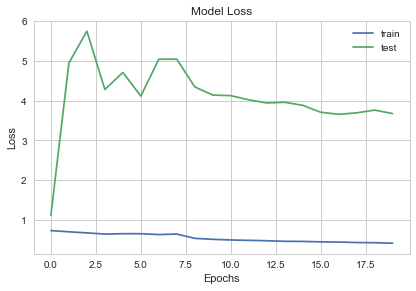

In [25]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

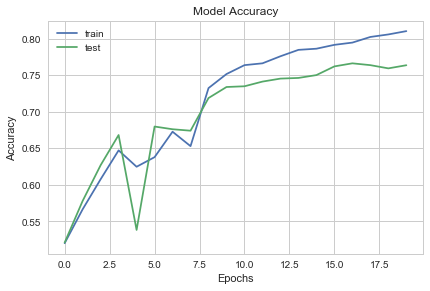

In [26]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [27]:
pred=model.predict(x_test)
pred_pet=np.argmax(pred,axis=1)

In [28]:
pred_pet

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [29]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_pet[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_pet[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

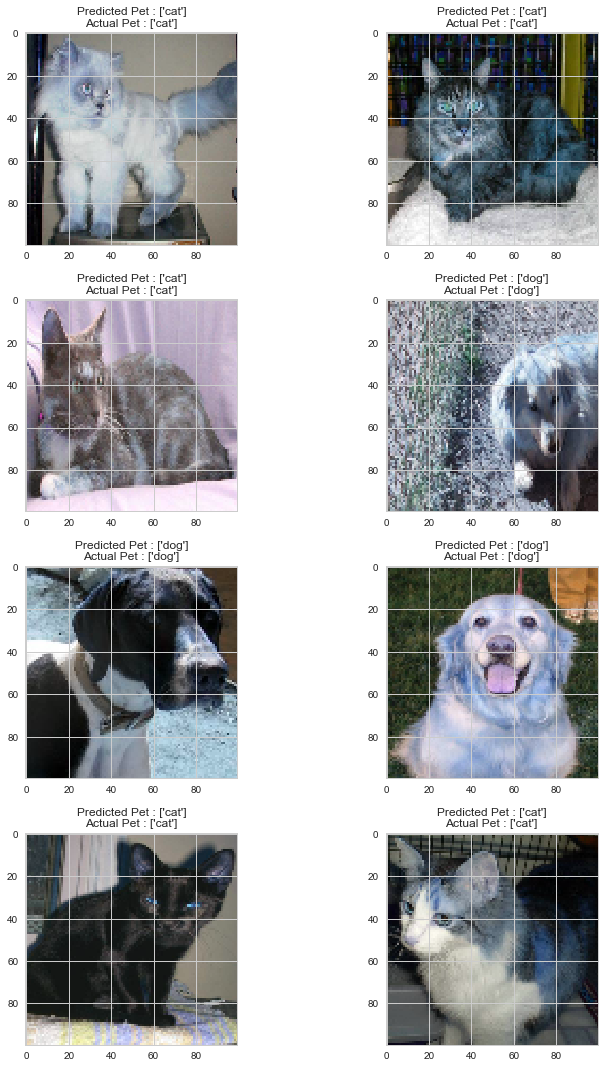

In [30]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Pet : "+str(le.inverse_transform([pred_pet[prop_class[count]]]))+"\n"+"Actual Pet : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

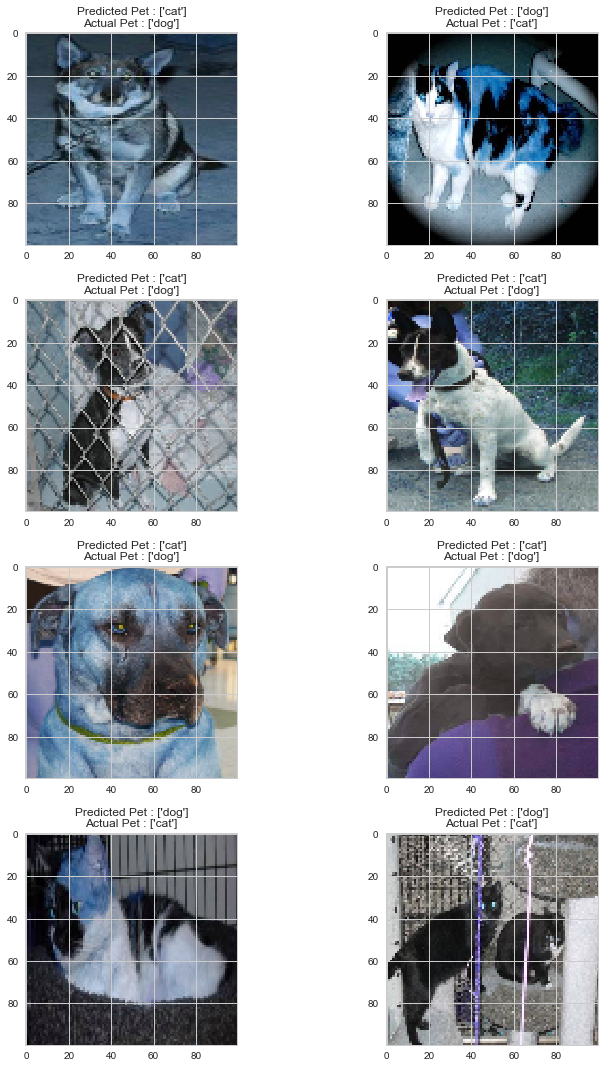

In [31]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Pet : "+str(le.inverse_transform([pred_pet[mis_class[count]]]))+"\n"+"Actual Pet : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

In [32]:
test_data=create_test_data()
test_data=np.array(test_data)
print(test_data.shape)
test= np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:30<00:00, 408.72it/s]


(12500, 1, 100, 100, 3)


In [33]:
pred=model.predict(test)

In [34]:
imageid=[]
pred_prob=[]
for i in range(len(test)):
    imageid.append(i+1)
    pred_prob.append(pred[i,1])
   
d={'id':imageid,'label':pred_prob}
ans=pd.DataFrame(d)
ans.to_csv('predictions.csv',index=False)